In [1]:
%%bash
mkdir Datasets/AccelClassification
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip -O Datasets/AccelClassification/Data.zip
cd Datasets/AccelClassification
unzip Data.zip

Archive:  Data.zip


mkdir: cannot create directory ‘Datasets/AccelClassification’: File exists
--2016-11-15 11:14:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00286/User%20Identification%20From%20Walking%20Activity.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1316158 (1.3M) [application/zip]
Saving to: ‘Datasets/AccelClassification/Data.zip’

     0K .......... .......... .......... .......... ..........  3%  212K 6s
    50K .......... .......... .......... .......... ..........  7%  644K 4s
   100K .......... .......... .......... .......... .......... 11%  658K 3s
   150K .......... .......... .......... .......... .......... 15% 1.27M 2s
   200K .......... .......... .......... .......... .......... 19% 1.19M 2s
   250K .......... .......... .......... .......... .......... 23%  698K 2s
   300K .......... .......

In [2]:
%%bash
cat Datasets/AccelClassification/User\ Identification\ From\ Walking\ Activity/README

1. Title: User Identification From Walking Activity
	Updated Nov, 2013 , P. Casale, email: plcasale@ieee.org
	
2. Abstract: The dataset collects data from an Android smartphone positioned in the chest pocket. Accelerometer Data are collected from 22 participants walking in the wild over a predefined path. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.

3. Relevant Information:
   --- The dataset collects data from an Android smartphone accelerometer positioned in the chest pocket
   --- Sampling frequency of the accelerometer: DELAY_FASTEST with network connections disabled
   --- Number of Participants: 22
   --- Data Format: CSV

4. Dataset Information
   --- Data are separated by participant
   --- Each file contains the following information
       ---- time-step, x acceleration, y acceleration, z acceleration
       
5. Reference Papers
       
  --- Casale, P. Pujol,

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd

from ggplot import ggplot, geom_line, aes, facet_grid, facet_wrap, ggtitle
import thinkplot
import matplotlib.pyplot as plt
import seaborn as sns

from thinkbayes2 import Suite, MakeNormalPmf, EvalNormalPdf, Joint
import os
from itertools import product

In [4]:
work_dir = "Datasets/AccelClassification/User Identification From Walking Activity/"
dfs = []
for fname in os.listdir(work_dir):
    if not fname.endswith('csv'):
        continue
    num = fname[:-len('.csv')]

    df = pd.read_csv(work_dir+fname, header=None, names=["Time", "x_ddot", "y_ddot", "z_ddot"])
    df["Subject"] = num
    dfs.append(df)
    
df = pd.concat(dfs)
df.head()

,Time,x_ddot,y_ddot,z_ddot,Subject
0,0.000000,0.69464,3.17350,7.5048,1
1,0.030639,0.14982,3.48680,9.2755,1
2,0.069763,-0.29965,1.94770,9.1120,1
3,0.099823,-1.68890,1.41650,10.1200,1
4,0.129820,-2.17930,0.95342,10.9240,1


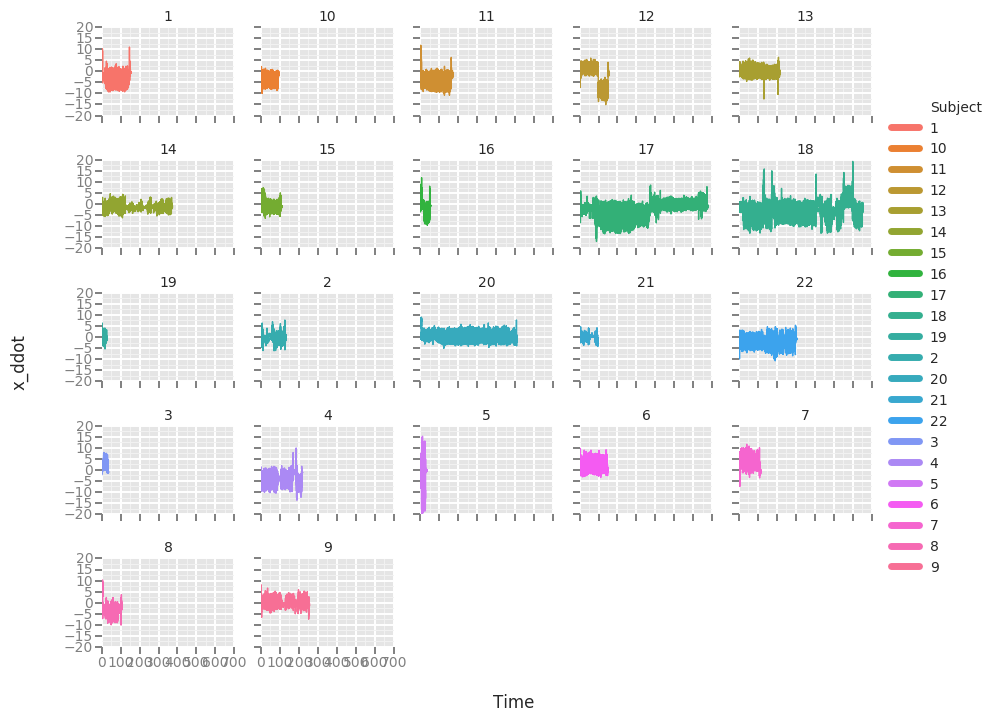

<ggplot: (8774866383894)>

In [5]:
g1 = ggplot(df,
       aes(x="Time",
           y="x_ddot",
           color="Subject")) + \
facet_wrap(x="Subject") +\
geom_line()

g2 = ggplot(df,
       aes(x="Time",
           y="x_ddot",
           color="Subject")) + \
facet_grid(x="Subject") +\
geom_line()
g1

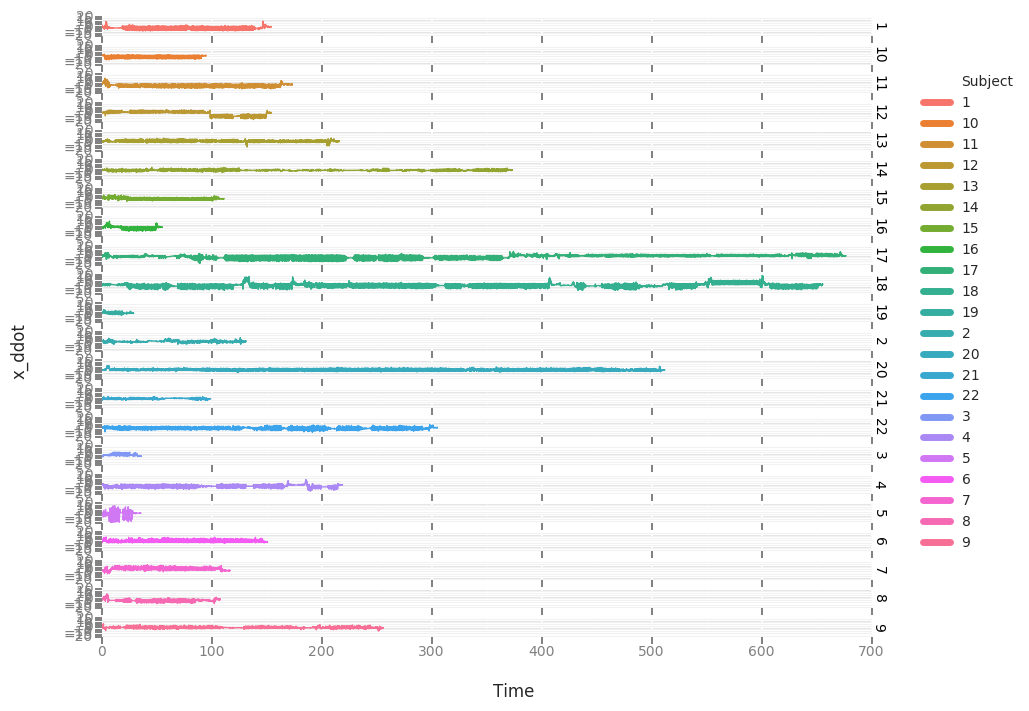

<ggplot: (8774866383922)>

In [6]:
g2

In [7]:
def MakeColNormals(df, groupby="Subject", norm_cols=['x_ddot', 'y_ddot', 'z_ddot']):
    mu_sigma = {}
    for l, cols_df in df.groupby(groupby):
        mu_sigma[l] = {}
        for col in cols_df.columns:
            if col not in norm_cols:
                continue

            accel_df = pd.DataFrame(cols_df[col])
            mu, sigma = (np.average(accel_df[col]), np.std(accel_df[col]))
            mu_sigma[l][col] = (mu, sigma)
    return mu_sigma

In [8]:
#Let's see if the normal-distribution generating structure proposed in report4 is generalizable
norms = MakeColNormals(df)


In [9]:
class NormalClassifier(Suite, Joint):
    def __init__(self, prior=None, norm_param=None):
        self.norm_param = norm_param
        Suite.__init__(self, prior)
        
    def Likelihood(self, data, hypo):
        data = data[1]
        activity = hypo
        likes = []
        for accel in data.keys():
            if not accel.endswith('ddot'):
                continue
            likes.append(EvalNormalPdf(data[accel], *self.norm_param[activity][accel]))
        return np.sum(likes)

def predict(df, train_rows=None, test_rows=None, n_samples=40):
    if train_rows == None:
        norms = MakeColNormals(df)
    else:
        norms = MakeColNormals(df.loc[[train_rows]])
        
    if test_rows == None:
        category = np.random.choice(list(set(df.Subject)))
        test_df = df[df.Subject==category].head(n_samples)
        
    else:
        test_df = df.loc[[test_rows]]
        
    trained_classifier = NormalClassifier(prior=set(df.Subject), norm_param=norms)
    trained_classifier.UpdateSet(test_df.iterrows())
    trained_classifier.Normalize()
    return (category, trained_classifier)

In [10]:
score = []
mispredict_counts = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    ans, pred = predict(df)
    win = pred.MAP()==ans
    score.append(win)
    if not win:
        mispredict_counts[pred.MAP()] = mispredict_counts.get(pred.MAP(), 0) + 1

0
10
20
30
40
50
60
70
80
90


In [11]:
np.sum(score)

8

In [12]:
mispredict_counts

{'14': 20, '19': 66, '21': 6}

In [13]:
del(norms['19'])
score = []
mispredict_counts = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    ans, pred = predict(df[df.Subject!=19])
    win = pred.MAP()==ans
    score.append(win)
    if not win:
        mispredict_counts[pred.MAP()] = mispredict_counts.get(pred.MAP(), 0) + 1

0
10
20
30
40
50
60
70
80
90


In [14]:
np.sum(score)

4

What? Why is our score so low? did things get misclassified?

In [15]:
mispredict_counts

{'14': 12, '19': 81, '21': 3}

Looks like we really like class 19, is this a flaw in our code? Let's check that with `sklearn`

In [16]:
from sklearn import naive_bayes

In [17]:
X = np.array(df.loc[:, "x_ddot":"z_ddot"])
y = np.array(df.Subject)

In [18]:
def gb_predict(df, train_rows=None, test_rows=None):
    if train_rows == None:
        norms = MakeColNormals(df)
    else:
        norms = MakeColNormals(df.loc[[train_rows]])
        
    if test_rows == None:
        category = np.random.choice(list(set(df.Subject)))
        test_df = df[df.Subject==category].head(1)
        test_X = np.array(test_df.loc[:, "x_ddot":"z_ddot"])
        
    else:
        test_df = df.loc[[test_rows]]
        
        
    
    X = np.array(df.loc[:, "x_ddot":"z_ddot"])
    y = np.array(df.Subject)
    trained_classifier = naive_bayes.GaussianNB().fit(X, y)
    ys = trained_classifier.predict(test_X)

    return (category, ys)

In [19]:
gb_predict(df)

('19', array(['18'], 
       dtype='<U2'))

In [20]:
score = []
mispredict_counts = {}
for i in range(100):
    if i%10 == 0:
        print(i)
    ans, pred = gb_predict(df)
    win = pred[0] ==ans
    score.append(win)
    if not win:
        mispredict_counts[pred[0]] = mispredict_counts.get(pred[0], 0) + 1

0
10
20
30
40
50
60
70
80
90


In [21]:
np.sum(score)

8

In [22]:
mispredict_counts

{'14': 29, '17': 7, '18': 54, '19': 2}

So why is our misclassification happening? It's not a problem with our code, rather a fundamental issue with a normally distributed gaussian process, the naive bayes classifier. To see why this happens, and what we can do to choose a different technique instead, we can examine the normal distributions themselves

In [23]:
norm_data = pd.DataFrame(norms).T
norm_data.head()

,x_ddot,y_ddot,z_ddot
1,"(-3.55425428369, 2.48638386327)","(8.5579894853, 2.95622549652)","(-0.844095408167, 2.91342009529)"
10,"(-3.28463971581, 2.01931488429)","(8.73187229423, 2.1933418263)","(-0.191077554763, 2.63259659502)"
11,"(-3.45704461604, 2.47327062814)","(8.58995666962, 2.20399905461)","(0.424913215756, 2.58220139263)"
12,"(-2.2036343955, 4.41484525335)","(7.67101873307, 2.82782656869)","(0.0835049660346, 2.82446841708)"
13,"(-0.325081352142, 1.61036857117)","(9.07254094342, 2.9581304465)","(1.49746832288, 2.47621114164)"


In [24]:

def visualize_norms(norms_df, min_mag, max_mag):
    mags = np.linspace(min_mag, max_mag, 1000)

    accel_contour = {}
    for accel_d in norms_df.columns:
        accel_contour[accel_d] = []
    for i_r, row in norms_df.iterrows():
        for accel_d, mu_sigma in row.iteritems():
            for mag in mags:
                norm_eval = EvalNormalPdf(mag, *mu_sigma)
                accel_contour[accel_d].append((i_r, mag, norm_eval))
            
    return accel_contour
        

In [25]:
accel_df = visualize_norms(norm_data, -20, 20)
x_df = pd.DataFrame(accel_df["x_ddot"], columns=['Subject', "Magnitude", "Data"])
y_df = pd.DataFrame(accel_df["y_ddot"], columns=['Subject', "Magnitude", "Data"])
z_df = pd.DataFrame(accel_df["z_ddot"], columns=['Subject', "Magnitude", "Data"])

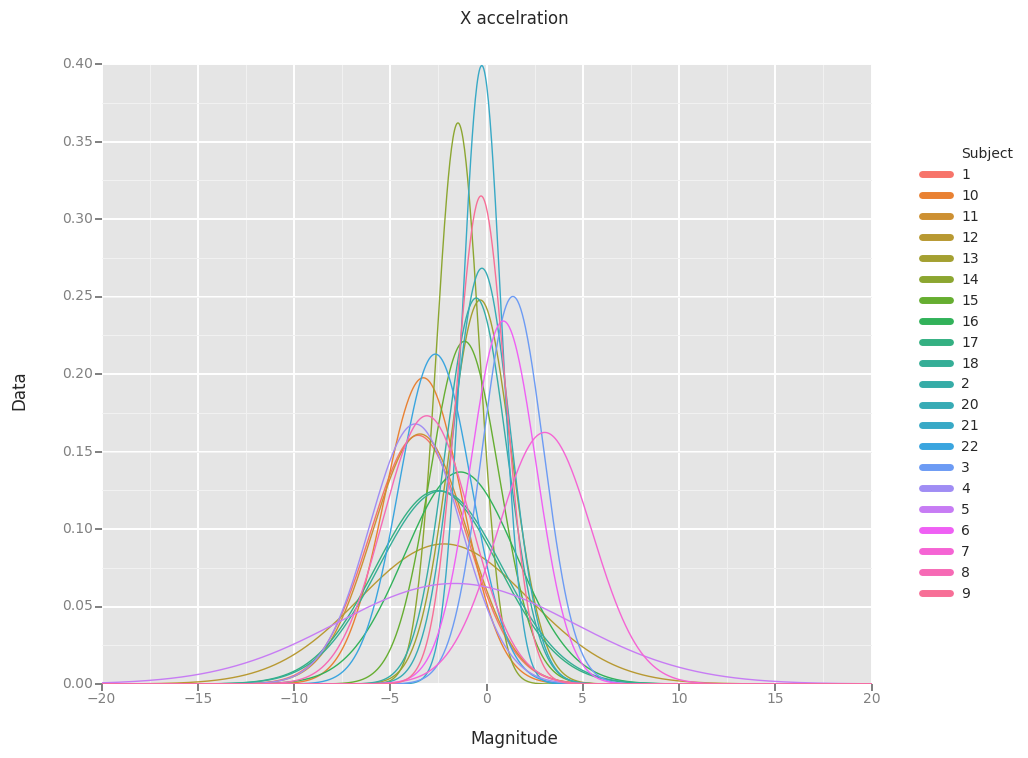

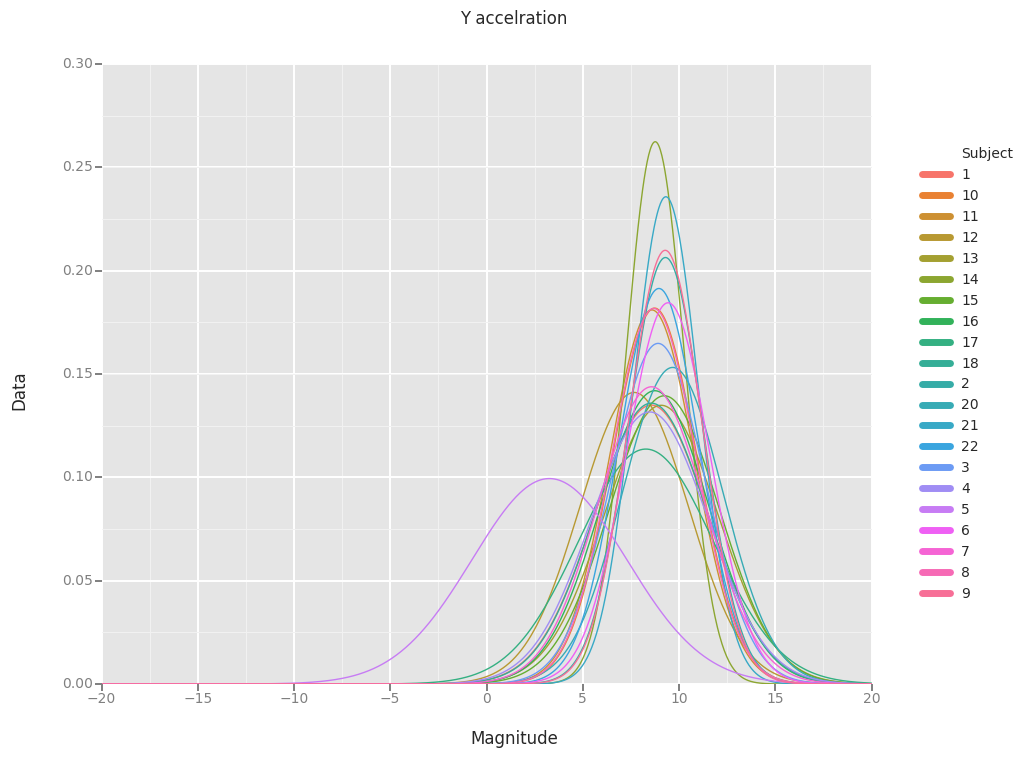

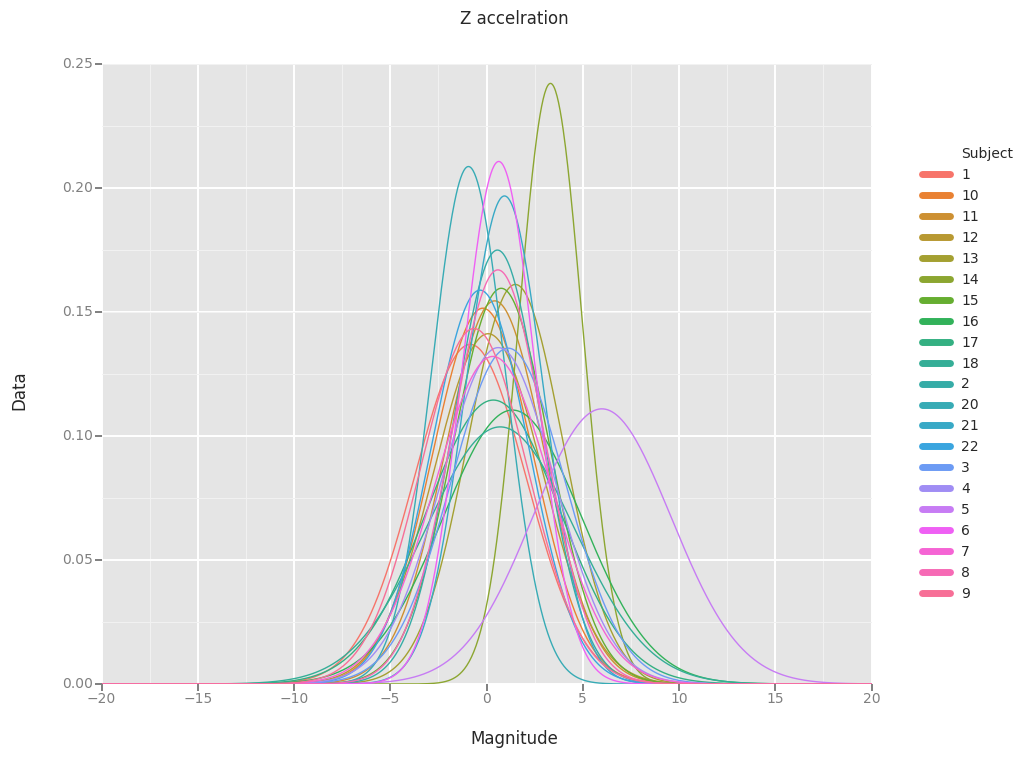

(<ggplot: (-9223363262015857625)>,
 <ggplot: (8774838918229)>,
 <ggplot: (8774838916598)>)

In [26]:
x_p = ggplot(x_df,
       aes(x="Magnitude",
           y="Data",
           color="Subject")) +\
geom_line()+\
ggtitle("X accelration")
y_p = ggplot(y_df,
       aes(x="Magnitude",
           y="Data",
           color="Subject")) +\
geom_line()+\
ggtitle("Y accelration")
z_p = ggplot(z_df,
       aes(x="Magnitude",
           y="Data",
           color="Subject")) +\
geom_line() +\
ggtitle("Z accelration")
x_p, y_p, z_p

Now we have a better idea of why it fails, the normal distributions are far too clumped together to allow for accurate classification. 